## Applicazione del transfer learning con MobileNet_V2
A high-quality, dataset of images containing fruits. The following fruits are included: Apples - (different varieties: Golden, Golden-Red, Granny Smith, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red), Cactus fruit, Carambula, Cherry, Clementine, Cocos, Dates, Granadilla, Grape (Pink, White, White2), Grapefruit (Pink, White), Guava, Huckleberry, Kiwi, Kaki, Kumsquats, Lemon (normal, Meyer), Lime, Litchi, Mandarine, Mango, Maracuja, Nectarine, Orange, Papaya, Passion fruit, Peach, Pepino, Pear (different varieties, Abate, Monster, Williams), Pineapple, Pitahaya Red, Plum, Pomegranate, Quince, Raspberry, Salak, Strawberry, Tamarillo, Tangelo.

Training set size: 28736 images.

Validation set size: 9673 images.

Number of classes: 60 (fruits).

Image size: 100x100 pixels.

In [0]:
import numpy as np
import keras
from tensorflow.keras.layers import InputLayer, Input, ReLU
from tensorflow.keras.layers import Reshape, MaxPooling2D, Cropping2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.applications.mobilenet_v2  import MobileNetV2
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras import backend as K

## Upload dataset to colab:
With the help of pydrive package it is possible to upload dataset which is a shared link on google drive directly to the colab. So no need to download the dataset and then upload it on google colab. It can be done right away. To proceed google need to authorize your account. Running below cell emarges a link that give you a code to authorize your google account to use google clould SDK. the last step is to copy and paste the code. Done!

In [29]:
# Google Drive Authentication
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Each shared file on google drive has a unique id. This id can be found in the shareable link of the file. So instead of file link we must use id to be capable upload the file to colab.

In [0]:
# Download a file from shareable Link on Elearning
file_id = '1wJw2Ugn0L0DZIs_3_oZ0KNoOFTFxOsFS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('FRUTTA.rar')


The uploaded file is a .rar extention file. The rarfile package can extract(unrar) file. 

In [4]:
# Unrar file on colab
!pip install rarfile
import rarfile
rf = rarfile.RarFile('FRUTTA.rar')
rf.extractall(path = 'FRUTTA')

     |████████████████████████████████| 112kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/dc/84/da/8aff50941f548db5384b076d5a6a6afea0cd12672e0326edc4
Successfully built rarfile


### Change the path of directories!!!

In [0]:
# Setting path location for validation, traing and testing images
validationPath = 'FRUTTA/Validation'
trainPath = 'FRUTTA/Training'

### Plot an image, for example E:/Training/Cocos/15_100.jpg

To show an image directly readed from the disk, IPython module is needed. However there are several ways to do that.   

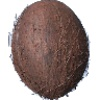

In [0]:
from IPython.display import Image as image_show
image_show('FRUTTA/Training/Cocos/15_100.jpg', width = 200, height = 200)

### Now you define the functions ables to read mini-batch of data

In [0]:
# Making an image data generator object with augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

In [0]:
# Making an image data generator object with no augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)

### why train_datagen and test_datagen are different? answer . . .

The idea for manipulating the train data set using rotation, zoom, width/height shift, flipping and process such like is that to expose the model with all probably possible samples that it may deal with on prediction/classification phase. So to streghten the model and getting the most information from train data, we manipulate the samples in train set such that the manipulated samples also can be valid and possible samples as part of train set. But if we do the same process on validation and test sets we will increase the correlation between train and validation/test sets that is in conflict with the assumtion that sample are independent. That causes generally more accuracy on validation and test sets which is not real. To recap, it is recommended that do manipulation just on seen data rather than unseen data.        

The beloved keras package make it easy to read image from the disk and convert it directly to a generator. we can do it with flow_from_directory method.

In [8]:
# Using the generator with batch size 32 for training directory
train_generator = train_datagen.flow_from_directory(trainPath, 
                                                    target_size=(128, 128),
                                                    batch_size=64,
                                                    class_mode='categorical')

Found 28736 images belonging to 60 classes.


In [9]:
# Using the generator with batch size 17 for validation directory
validation_generator = test_datagen.flow_from_directory(validationPath,
                                                        target_size=(128, 128),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 9673 images belonging to 60 classes.


### you can control the dimensions of the generator outputs

In [10]:
validation_generator[0][0].shape

(64, 128, 128, 3)

Since on training phase for each epoch once gradian descend algorithm run on each mini-batch. we set the mini-batch to 64. But for validation there is no significant diffrence for small or large mini-batch size as it is only used to derive validation metrices. 

In [11]:
print("Number of batches in validation generator is", len(validation_generator))
print("Number of batches in train generator is", len(train_generator))


Number of batches in validation generator is 152
Number of batches in train generator is 449


In [12]:
validation_generator[0][1].shape

(64, 60)

### Now you need to define your model . . .
the default definition of MobileNet_V2 is:

MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

but you have a different number of classes . . . . .

# Using MobileNetV2:
It is possible to use a pre-trained model such as MobileNetV2 and the keras package enable us to modify the model to 60 class

MobileNetV2 is a deep CNN model with 20 sequentional layers that is trained to classify 1000 classes. In this project we only have 60 classes, So the top layer are dropped must be substitute with final output layers which includes usually GlobalAveraging and Dense layer. First the a look at the MobileNetV2 as a base model that is shown below:  

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________

### Define what layers you want to train . . .

In order to use a pre-trained model like MobileNetV2 for only 60 classes we can keep the layers freezed and just only drop the last layers which is done setting top_layer=False.
In below code the last two layers were removed and substituted with an average pooling and a dense layer. Adding up the base model and trainable layers, the new model summarize as below. It can be seen that the shape of each output layer is None that stem from dropping top layer in base model causes the model to train with different input shape.

In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(60, activation = 'softmax')(x)
model_mnv2 = Model(inputs = base_model.input, outputs = predictions)
print(model_mnv2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

The below code freez the layers setup from base_model and keep the rest layers trainable. It provide us with chance of using the weight of the base model in or new model that is going to be modified to cover 60 classes of fruits.

In [0]:
for layer in base_model.layers:
  layer.trainable = False


### Compile the model . . .

Now we have the model and we defined its architecture. It is time to compile the model and determine the optimizer algorithm, the loss function which is used in optimization and the metrices that are intresting to monitor. 

In [0]:
model_mnv2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## to fit the model you can write an expression as:
history = model.fit_generator(train_generator,
                              epochs=20,validation_data=validation_generator,)

The way keras train a model and make prediction is diffrent. In diffrent modes some layers such as batch_normalization operate diffrent. For example in train mode the mean and variance of each mini_batch is used to rescale the tensors but in test mode the moving average of mean and variance is pluging in for rescaling. So what is the problem. If the mode is set test and we train the data. The model shows a significant fit on train data but very poor results on validation data which is not a real overfitting problem. To understand when the result steming from this problem it is better to use same data for both train and validation. when the results in train and validation are different means that the learning phase is wrong.

In [0]:
history = model_mnv2.fit_generator(validation_generator,
                             epochs=5,validation_data=validation_generator)
model_mnv2.save('testlp.h5')
####WARNING!!!!!!The below code make a copy of the model file on your google drive. keep it comment if you dont want the copy 
model_file = drive.CreateFile({'title' : 'testlp.h5'})
model_file.SetContentFile('testlp.h5')
model_file.Upload()

It can be seen that with feeding the model the same data for both train and validation, the resuts of each epoch is sharply different. Let change the learning phase 

In [26]:
K.clear_session()
K.set_learning_phase(1)
model_mnv2 = load_model('testlp.h5')
print(model_mnv2.evaluate_generator(validation_generator))

[0.06165256894784857, 0.9829422]


Setting learning phase to train yields the same results. So keep the learning phase equal 1 to set it as train for the rest part of training the model.

In [0]:
for layer in model_mnv2.layers:
  layer.trainable = False
model_mnv2.layers[-1].trainable = True
model_mnv2.layers[-2].trainable = True
model_mnv2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_mnv2.fit_generator(train_generator,
                             epochs=5,validation_data=validation_generator)

model_mnv2.save('mnv2_01.h5')
####WARNING!!!!!!The below code make a copy of the model file on your google drive. keep it comment if you dont want the copy 
model_file = drive.CreateFile({'title' : 'mnv2_01.h5'})
model_file.SetContentFile('mnv2_01.h5')
model_file.Upload()

### Fine tuning?

Although training the model only on last two layer make happy with 99.8% accuracy on validation data (there is still difference between train and validation accuracy train_acc < val_acc keeping in mind we manipulated the train data but not the test data). It might can be even better. Lets give a try to fine tuning and release the constrains of frozen layers.

In [0]:
K.clear_session()
K.set_learning_phase(1)
model_mnv2 = load_model('mnv2_01.h5')
for layer in model_mnv2.layers:
  layer.trainable = True
model_mnv2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_mnv2.fit_generator(train_generator,
                             epochs=20,validation_data=validation_generator)
model_mnv2.save('mnv2_final.h5')
####WARNING!!!!!!The below code make a copy of the model file on your google drive. keep it comment if you dont want the copy 
model_file = drive.CreateFile({'title' : 'mnv2_final.h5'})
model_file.SetContentFile('mnv2_final.h5')
model_file.Upload()


Epoch 1/20
449/449 [==============================] - 157s 349ms/step - loss: 0.0122 - acc: 0.9970 - val_loss: 2.2130 - val_acc: 0.8122
Epoch 2/20
449/449 [==============================] - 152s 338ms/step - loss: 0.0121 - acc: 0.9973 - val_loss: 4.2625 - val_acc: 0.6612
Epoch 3/20
449/449 [==============================] - 151s 336ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 7.9470 - val_acc: 0.4138
Epoch 4/20
449/449 [==============================] - 150s 335ms/step - loss: 0.0101 - acc: 0.9977 - val_loss: 2.7799 - val_acc: 0.7455
Epoch 5/20
449/449 [==============================] - 151s 335ms/step - loss: 0.0099 - acc: 0.9978 - val_loss: 1.8795 - val_acc: 0.8247
Epoch 6/20
449/449 [==============================] - 153s 340ms/step - loss: 0.0077 - acc: 0.9979 - val_loss: 2.0416 - val_acc: 0.8302
Epoch 7/20
449/449 [==============================] - 151s 337ms/step - loss: 0.0121 - acc: 0.9974 - val_loss: 2.3354 - val_acc: 0.8107
Epoch 8/20
449/449 [============================

### once you have obtained the final estimate of the model you must evaluate it with more details . . .

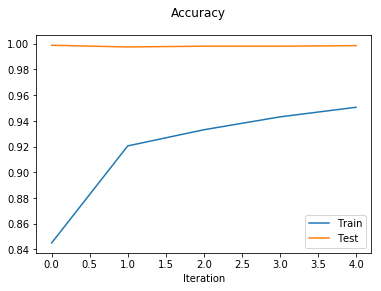

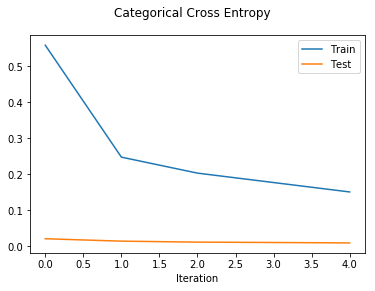

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.suptitle('Accuracy')
plt.xlabel('Iteration')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.suptitle('Categorical Cross Entropy')
plt.xlabel('Iteration')
plt.show()

### take an image of a papaya from internet and try to apply your model . . .

In [115]:
import requests
f = open('papaya.jpg','wb')
f.write(requests.get('https://www.xspo.it/media/image/16/0a/59/18_m-neal-pt_apple-green_600x600.jpg').content)
f.close()
img = image.load_img('papaya.jpg', target_size=(128, 128))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
img_pred = int(model_mnv2.predict(img).argmax(axis=-1))
x = list(validation_generator.class_indices.keys())
print(x[img_pred])

(1, 128, 128, 3)
Apple Red Yellow
